In [58]:
import pandas as pd
from tqdm.auto import tqdm
import requests
import time
import geopandas as gpd
from shapely.geometry import box
from requests_cache import CachedSession

session = CachedSession(
    'cache',
    allowable_methods=['GET', 'POST'], # Cache whatever HTTP methods you want
    stale_if_error=True,               # In case of request errors, use stale cache data if possible
)

pd.set_option('display.max_columns', None)
df = pd.read_csv("overture_NZ.csv")
df

,name,main_category,alternate_categories,lat,lng
0,Pearl Island,landmark_and_historical_building,"island,monument",-47.189700,167.706000
1,Kopeka River,river,NaN,-47.133333,167.933333
2,Toitoi River,river,NaN,-47.116667,167.983333
3,Lords River,river,NaN,-47.116667,168.150000
4,Rakeahua River,river,NaN,-46.983333,167.900000
...,...,...,...,...,...
137738,"Araraiti Bay, Whananaki",beach,structure_and_geography,-35.507186,174.466459
137739,Motutara Farm,campground,"farm,hotel",-35.505100,174.467260
137740,Whananaki North Doc Camp,campground,NaN,-35.501872,174.468942
137741,Otamure Bay Camp Site,campground,"beach,structure_and_geography",-35.491876,174.463143


In [6]:
df[df.main_category == "cafe"]

,name,main_category,alternate_categories,lat,lng
24,The Snuggery,cafe,coffee_shop,-46.899385,168.128194
40,Just Cafe,cafe,"coffee_shop,desserts",-46.897857,168.127494
42,The Old Butchershop Café - Stewart Island,cafe,coffee_shop,-46.897781,168.127823
104,"Bluff Café, Kawhe - temporary closed",cafe,"coffee_shop,tea_room",-46.599205,168.344704
105,Oyster Allsorts,cafe,"museum,souvenir_shop",-46.599210,168.344792
...,...,...,...,...,...
137496,Cafe North - Refining,cafe,"coffee_shop,internet_cafe",-35.839460,174.486530
137513,The Deck Cafe,cafe,"restaurant,grocery_store",-35.819350,174.503585
137571,New day cafe & restaurant,cafe,"indian_restaurant,restaurant",-35.769214,174.480556
137591,Tahi Cafe,cafe,"coffee_shop,breakfast_and_brunch_restaurant",-35.702640,174.510200


In [70]:
auth_token = open("auth_token").read().strip()

In [32]:
places = []
for row in tqdm(df[df.main_category == "cafe"].itertuples(index=False), total=df[df.main_category == "cafe"].shape[0]):
  r = session.post("https://content-places.googleapis.com/v1/places:searchText?fields=*&alt=json", headers={
      "authorization": auth_token
    }, json={
      "textQuery": row.name,
      "locationBias": {
        "circle": {
          "center": {
            "latitude": row.lat,
            "longitude": row.lng
          },
          "radius": 500.0
        }
      }
  })
  r.raise_for_status()
  r = r.json()
  if "places" in r:
    places.extend(r["places"])

  0%|          | 0/3597 [00:00<?, ?it/s]

In [33]:
cafes = pd.json_normalize(places).drop_duplicates("id")
cafes

,name,id,types,formattedAddress,addressComponents,rating,googleMapsUri,websiteUri,utcOffsetMinutes,adrFormatAddress,businessStatus,priceLevel,userRatingCount,iconMaskBaseUri,iconBackgroundColor,takeout,delivery,dineIn,curbsidePickup,reservable,servesBreakfast,servesLunch,servesBeer,servesWine,servesBrunch,servesVegetarianFood,primaryType,shortFormattedAddress,reviews,photos,outdoorSeating,liveMusic,servesCocktails,servesDessert,servesCoffee,goodForChildren,restroom,goodForGroups,plusCode.globalCode,plusCode.compoundCode,location.latitude,location.longitude,viewport.low.latitude,viewport.low.longitude,viewport.high.latitude,viewport.high.longitude,regularOpeningHours.openNow,regularOpeningHours.periods,regularOpeningHours.weekdayDescriptions,displayName.text,displayName.languageCode,primaryTypeDisplayName.text,primaryTypeDisplayName.languageCode,currentOpeningHours.openNow,currentOpeningHours.periods,currentOpeningHours.weekdayDescriptions,paymentOptions.acceptsCreditCards,paymentOptions.acceptsDebitCards,paymentOptions.acceptsCashOnly,paymentOptions.acceptsNfc,parkingOptions.freeParkingLot,parkingOptions.freeStreetParking,accessibilityOptions.wheelchairAccessibleParking,accessibilityOptions.wheelchairAccessibleEntrance,accessibilityOptions.wheelchairAccessibleRestroom,accessibilityOptions.wheelchairAccessibleSeating,nationalPhoneNumber,internationalPhoneNumber,servesDinner,menuForChildren,goodForWatchingSports,allowsDogs,parkingOptions.paidGarageParking,parkingOptions.paidParkingLot,parkingOptions.paidStreetParking,parkingOptions.freeGarageParking,editorialSummary.text,editorialSummary.languageCode,parkingOptions.valetParking,generativeSummary.overview.text,generativeSummary.overview.languageCode,currentSecondaryOpeningHours,regularSecondaryOpeningHours,generativeSummary.description.text,generativeSummary.description.languageCode,generativeSummary.references.reviews,evChargeOptions.connectorCount,evChargeOptions.connectorAggregation,currentOpeningHours.specialDays
0,places/ChIJnQPf_KtfzakRitq1bpCivZY,ChIJnQPf_KtfzakRitq1bpCivZY,"[cafe, coffee_shop, food, store, point_of_inte...","9 Ayr Street, Oban 9818, New Zealand","[{'longText': '9', 'shortText': '9', 'types': ...",4.9,https://maps.google.com/?cid=10862016617503906442,http://fb.com/TheSnuggeryRakiura,720,"<span class=""street-address"">9 Ayr Street</spa...",OPERATIONAL,PRICE_LEVEL_MODERATE,130.0,https://maps.gstatic.com/mapfiles/place_api/ic...,#FF9E67,True,False,True,False,False,True,True,True,True,True,True,cafe,"9 Ayr St, Oban",[{'name': 'places/ChIJnQPf_KtfzakRitq1bpCivZY/...,[{'name': 'places/ChIJnQPf_KtfzakRitq1bpCivZY/...,True,False,False,True,True,True,True,True,4V5C442H+68,"442H+68 Oban, Southland, New Zealand",-46.899455,168.128263,-46.900720,168.126834,-46.898022,168.129532,False,"[{'open': {'day': 2, 'hour': 8, 'minute': 0}, ...","[Monday: Closed, Tuesday: 8:00 AM – 3:30 PM, W...",The Snuggery,en,Cafe,en,False,"[{'open': {'day': 2, 'hour': 8, 'minute': 0, '...","[Monday: Closed, Tuesday: 8:00 AM – 3:30 PM, W...",True,True,False,True,True,True,True,True,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,places/ChIJg-M3guopCTkRq2FNTkGZ7t4,ChIJg-M3guopCTkRq2FNTkGZ7t4,"[cafe, coffee_shop, chinese_restaurant, vegeta...","32, Rajpur Rd, opposite Post Office, Clock Tow...","[{'longText': '32', 'shortText': '32', 'types'...",4.2,https://maps.google.com/?cid=16063945426642756011,NaN,330,"<span class=""street-address"">32, Rajpur Rd</sp...",OPERATIONAL,PRICE_LEVEL_MODERATE,1103.0,https://maps.gstatic.com/mapfiles/place_api/ic...,#FF9E67,True,True,True,True,True,True,True,False,False,True,True,cafe,"32, Rajpur Rd, Post Office, Clock Tower, New M...",[{'name': 'places/ChIJg-M3guopCTkRq2FNTkGZ7t4/...,[{'name': 'places/ChIJg-M3guopCTkRq2FNTkGZ7t4/...,False,False,False,True,True,True,False,True,8J2W82FR+RW,"82FR+RW Dehradun, Uttarakhand, India",30.324607,78.042361,30.323258,78.041012,30.325956,78.043710,True,"[{'open': {'day

,name,id,types,formattedAddress,addressComponents,rating,googleMapsUri,websiteUri,utcOffsetMinutes,adrFormatAddress,businessStatus,priceLevel,userRatingCount,iconMaskBaseUri,iconBackgroundColor,takeout,delivery,dineIn,curbsidePickup,reservable,servesBreakfast,servesLunch,servesBeer,servesWine,servesBrunch,servesVegetarianFood,primaryType,shortFormattedAddress,reviews,photos,outdoorSeating,liveMusic,servesCocktails,servesDessert,servesCoffee,goodForChildren,restroom,goodForGroups,plusCode.globalCode,plusCode.compoundCode,location.latitude,location.longitude,viewport.low.latitude,viewport.low.longitude,viewport.high.latitude,viewport.high.longitude,regularOpeningHours.openNow,regularOpeningHours.periods,regularOpeningHours.weekdayDescriptions,displayName.text,displayName.languageCode,primaryTypeDisplayName.text,primaryTypeDisplayName.languageCode,currentOpeningHours.openNow,currentOpeningHours.periods,currentOpeningHours.weekdayDescriptions,paymentOptions.acceptsCreditCards,paymentOptions.acceptsDebitCards,paymentOptions.acceptsCashOnly,paymentOptions.acceptsNfc,parkingOptions.freeParkingLot,parkingOptions.freeStreetParking,accessibilityOptions.wheelchairAccessibleParking,accessibilityOptions.wheelchairAccessibleEntrance,accessibilityOptions.wheelchairAccessibleRestroom,accessibilityOptions.wheelchairAccessibleSeating,nationalPhoneNumber,internationalPhoneNumber,servesDinner,menuForChildren,goodForWatchingSports,allowsDogs,parkingOptions.paidGarageParking,parkingOptions.paidParkingLot,parkingOptions.paidStreetParking,parkingOptions.freeGarageParking,editorialSummary.text,editorialSummary.languageCode,parkingOptions.valetParking,generativeSummary.overview.text,generativeSummary.overview.languageCode,currentSecondaryOpeningHours,regularSecondaryOpeningHours,generativeSummary.description.text,generativeSummary.description.languageCode,generativeSummary.references.reviews,evChargeOptions.connectorCount,evChargeOptions.connectorAggregation,currentOpeningHours.specialDays,geometry
0,places/ChIJnQPf_KtfzakRitq1bpCivZY,ChIJnQPf_KtfzakRitq1bpCivZY,"[cafe, coffee_shop, food, store, point_of_inte...","9 Ayr Street, Oban 9818, New Zealand","[{'longText': '9', 'shortText': '9', 'types': ...",4.9,https://maps.google.com/?cid=10862016617503906442,http://fb.com/TheSnuggeryRakiura,720,"<span class=""street-address"">9 Ayr Street</spa...",OPERATIONAL,PRICE_LEVEL_MODERATE,130.0,https://maps.gstatic.com/mapfiles/place_api/ic...,#FF9E67,True,False,True,False,False,True,True,True,True,True,True,cafe,"9 Ayr St, Oban",[{'name': 'places/ChIJnQPf_KtfzakRitq1bpCivZY/...,[{'name': 'places/ChIJnQPf_KtfzakRitq1bpCivZY/...,True,False,False,True,True,True,True,True,4V5C442H+68,"442H+68 Oban, Southland, New Zealand",-46.899455,168.128263,-46.900720,168.126834,-46.898022,168.129532,False,"[{'open': {'day': 2, 'hour': 8, 'minute': 0}, ...","[Monday: Closed, Tuesday: 8:00 AM – 3:30 PM, W...",The Snuggery,en,Cafe,en,False,"[{'open': {'day': 2, 'hour': 8, 'minute': 0, '...","[Monday: Closed, Tuesday: 8:00 AM – 3:30 PM, W...",True,True,False,True,True,True,True,True,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (168.12826 -46.89945)
2,places/ChIJh2rwzG1fzakR4392B-vHMxo,ChIJh2rwzG1fzakR4392B-vHMxo,"[cafe, food, point_of_interest, establishment]","6 Main Road, Oban 9818, New Zealand","[{'longText': '6', 'shortText': '6', 'types': ...",4.8,https://maps.google.com/?cid=1888072481054818275,NaN,720,"<span class=""street-address"">6 Main Road</span...",CLOSED_TEMPORARILY,NaN,33.0,https://maps.gstatic.com/mapfiles/place_api/ic...,#FF9E67,True,True,True,False,True,True,True,True,True,NaN,True,cafe,"6 Main Rd, Oban",[{'name': 'places/ChIJh2rwzG1fzakR4392B-vHMxo/...,[{'name': 'places/ChIJh2rwzG1fzakR4392B-vHMxo/...,True,False,True,NaN,True,True,True,NaN,4V5C442H+V2,"442H+V2 Oban, Southland, New Zealand",-46.897869,168.127520,-46.899254,168.126172,-46.896556,168.128869,NaN,NaN,NaN,The Old Butchershop Café - Stewart Is

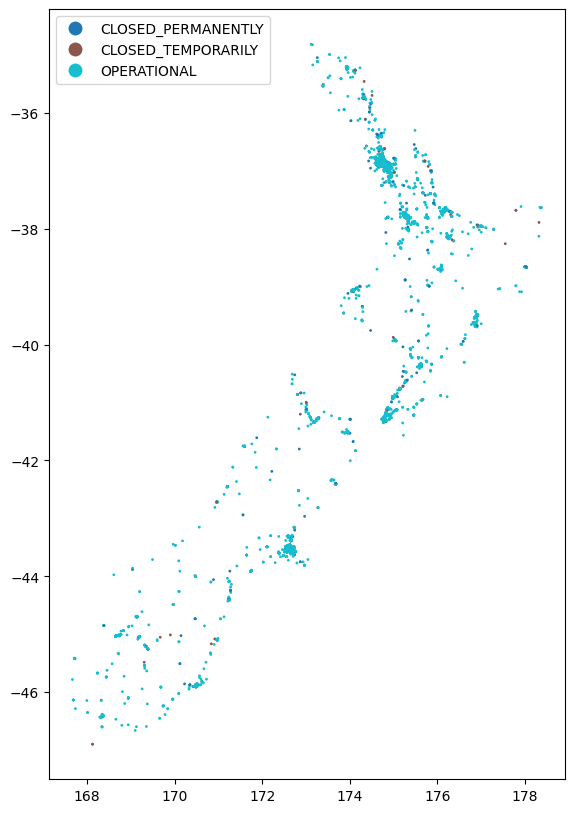

In [71]:
cafe_gdf = gpd.GeoDataFrame(cafes, geometry=gpd.points_from_xy(cafes["location.longitude"], cafes["location.latitude"]), crs=4326)
nz_bounds = box(163.08,-50.12,180,-31.31)
nz_cafes = cafe_gdf[cafe_gdf.within(nz_bounds)]
nz_cafes.plot("businessStatus", legend=True, figsize=(10,10), markersize=1)
nz_cafes

In [72]:
nz_cafes = nz_cafes[nz_cafes.businessStatus == "OPERATIONAL"]
print(len(nz_cafes))
nz_cafes.primaryType.value_counts().head(20)

4371


cafe                     2085
restaurant                531
coffee_shop               210
bakery                    134
bar                        83
gas_station                82
store                      67
convenience_store          64
meal_takeaway              61
grocery_store              49
fast_food_restaurant       38
turkish_restaurant         30
sandwich_shop              26
vietnamese_restaurant      24
japanese_restaurant        23
point_of_interest          22
supermarket                21
chinese_restaurant         17
car_repair                 17
event_venue                16
Name: primaryType, dtype: int64

Text(0.5, 1.0, 'Cafes in New Zealand by Rating')

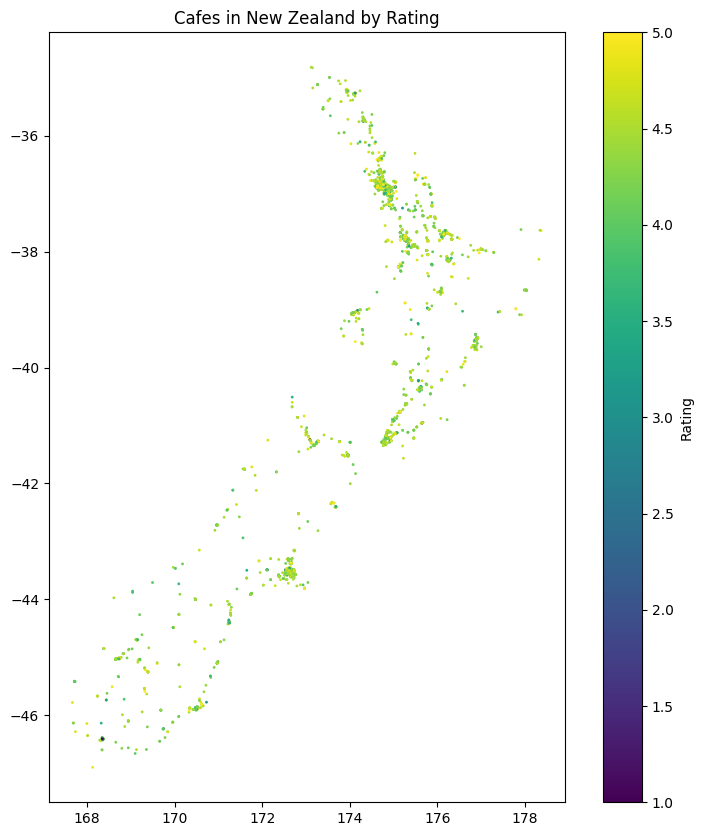

In [73]:
ax = nz_cafes.plot("rating", legend=True, figsize=(10,10), legend_kwds={"label": "Rating"}, markersize=1)
ax.set_title("Cafes in New Zealand by Rating")

In [74]:
nz_cafes.to_csv("nz_cafes.csv.zip", index=False)